# <center> TP2: Expectation-Maximization algorithm - Importance sampling

### Realized by: Siwar Mhadhbi

---

In [2]:
from scipy.stats import multivariate_normal
from IPython.core.display import HTML
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import copy

import warnings
warnings.simplefilter("ignore")

import seaborn as sns
sns.set(style='darkgrid')

plt.rcParams['figure.figsize'] = 15, 8

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Exercise 1. Discrete distributions

#### Question1.

To generate a random variable $X$ having the discrete distribution on $X$ given by $(p_i)_{i \in [1,n]}$, we can use the **inverse transform sampling**, which is the basic method to generate sample numbers at random from any probability distribution given its cumulative distribution function.<br>
To do so,

* we compute first the cumulative distribution function F.
* we sample $U_i \sim U[0,1] ~~iid$.
* we compute $X_i = F^{-1}(U_i)$. <br>
Where : <br> <br>
$F^{-1} : ~ ]0,1[ \rightarrow \mathbb{R}$<br>
$~~~~~~~~~~~~~~u   ~~ \mapsto inf\{x \in \mathbb{R} | F(x) \ge u\} $

Therefore, the computed $X_i$ are the generated random variables following the distribution $(p_i)_{i \in [1,n]}$, with :

$$\forall i \in [1,n], P(X=x_i) = p_i. $$
$$\forall i \in [1,n], p_i >0 ~~~and~~~ \sum_{i=1}^n p_i =1.$$

#### Question2.

Corresponding algorithm generating a discrete distribution:

In [3]:
def sample_discrete_distribution(p, n):

    # cumulative distribution function
    F = np.concatenate([[0.0], np.cumsum(p, dtype=float)])

    # uniform random distribution
    U = np.random.uniform(0, 1, n)

    # X_i = F^-1(U_i) : index where F = u
    dist = np.zeros(n)
    for i in range(n-1):
        index = np.where(F <= U[i])[0]
        dist[i] = index[len(index)-1]
    return dist

#### Question3.

We generate for this question a target distribution $X$ that we choose a uniform distribtion on $[0,1]$, we calculate its discrete distribution $p$ and sample according to $p$ using the method of $Question2$. <br>
As a result, we obtain a distribution close to the target one as shown by the figure below.

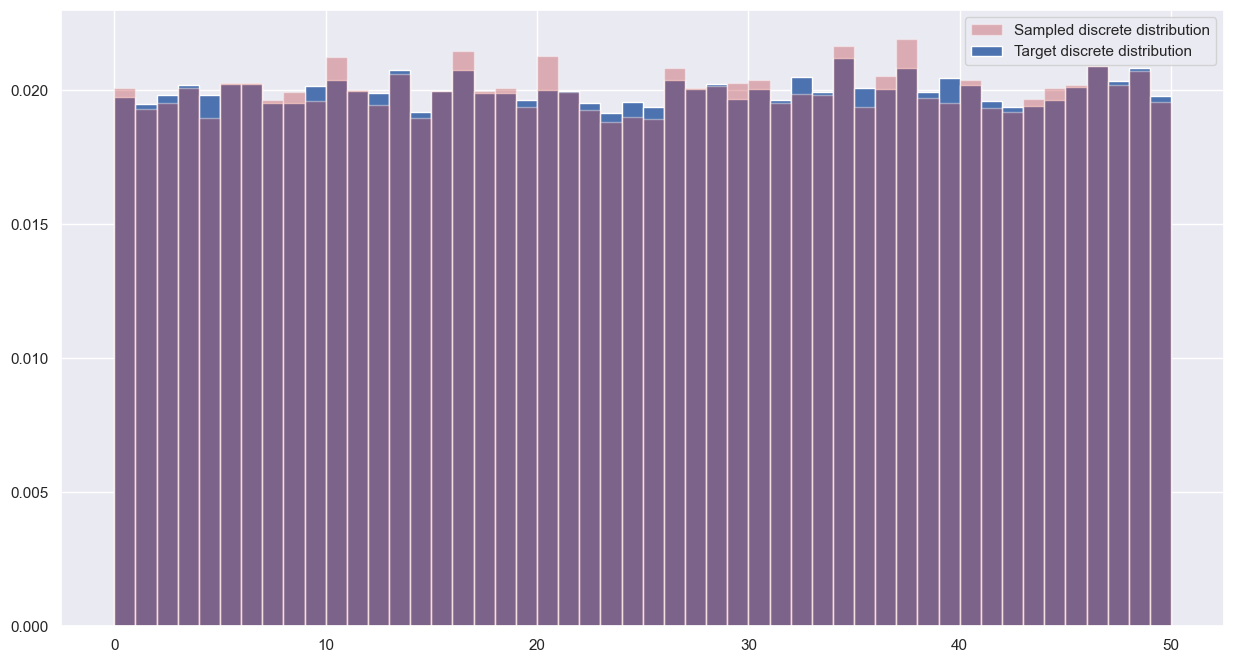

In [4]:
import numpy as np

n = 100000

# target distribution
X = np.random.uniform(0, 1, n)

# target discrete distribution
p, bins = np.histogram(X, bins=50)
p = p/np.sum(p)

# generated discrete distribution
simulations_p = sample_discrete_distribution(p, n)

# visualization
plt.bar(range(0, len(p)), p, fill=True,
        label='Target discrete distribution', width=1, align='edge')
plt.hist(simulations_p, range(0, len(p)+1), density=True, alpha=0.4,
         label='Sampled discrete distribution', color='r')
plt.legend();

# Exercise 2. Gaussian mixture model and the EM algorithm

#### Question1.

The parameters of the Gaussian mixture model are: $$\theta=(\alpha_{1},...,\alpha_{m}~,~\mu_{1},...,\mu_{m}~,~\Sigma_{1},...,\Sigma_{m})$$

The likelihood of $\theta$ given the realizations $(x_i)_{i\in [1,n]}$ of the i.i.d n-sample $(X_i)_{i \in [1,n]}$ is given by:

$$L(x_1,...,x_n;\theta) = \prod_{i=1}^n f_{\theta}(x_i) = \prod_{i=1}^n (\sum_{j=1}^m f_{\theta}(x_i|z_i = j) p(z_i = j)) ~~~~~~~~ (Law~~ of ~~total ~~probability)$$ 
$$ = \prod_{i=1}^n \sum_{j=1}^m \alpha_j f_{\theta}(x_i|z_i = j) ~~~~~~~~~~~~~~~~~~~$$

Where, $ f_{\theta}(x_i|z_i = j)$ is the probability density function of a multivariate normal distribution with mean $\mu_j$ and covariance matrix $\Sigma_j$.

#### Question2.

In this question, we sample a set of observation according to a Gaussian mixture law with the parameters $\mu_0, ~\alpha_0$ and $\Sigma_0$ as defined below.

In [5]:
def sample_GMM(mu, alpha, sigma, n):
    Z, X, classs = sample_discrete_distribution(alpha, n), [], []
    for i, z in enumerate(Z):
        X.append(np.random.multivariate_normal(mu[int(z)], sigma[int(z)]))
        classs.append(z)
    X = np.array(X)
    return X, classs

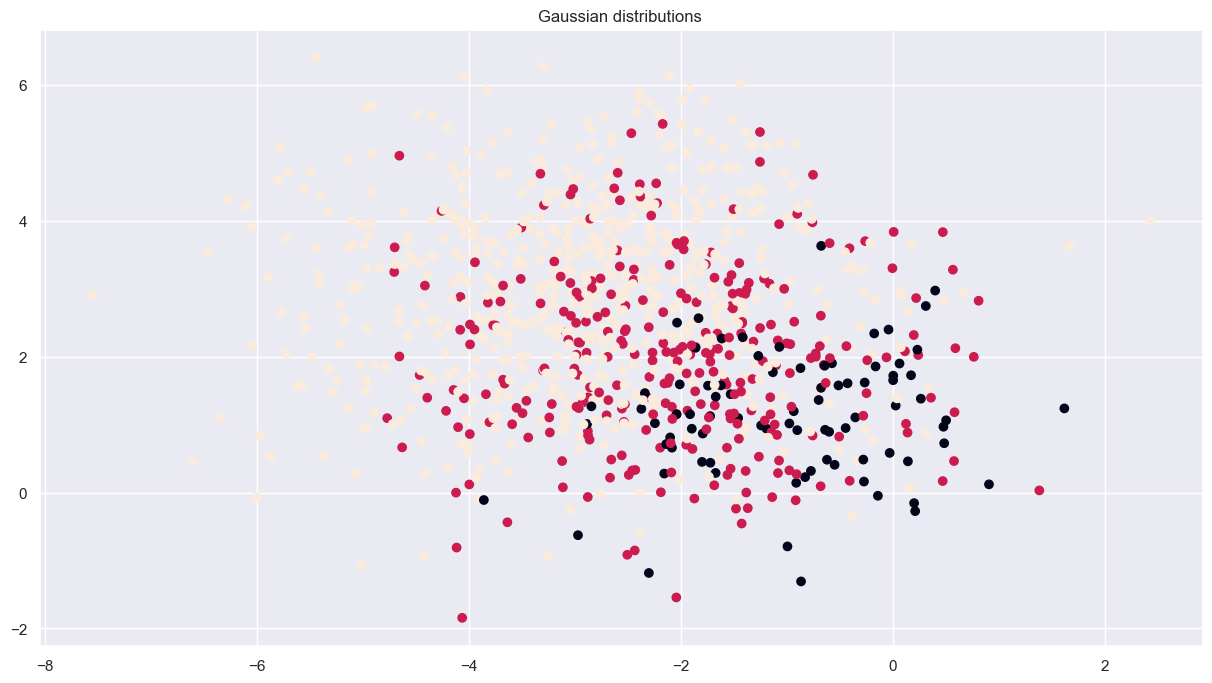

In [13]:
n = 1000

mu_0 = [np.array([-1, 1]), np.array([-2, 2]), np.array([-3, 3])]

sigma_1 = np.identity(2)
sigma_2 = 1.5*np.identity(2)
sigma_3 = 2*np.identity(2)
sigma_0 = [sigma_1, sigma_2, sigma_3]

alpha_0 = np.array([0.1, 0.3, 0.6])

data_gmm, classes = sample_GMM(mu_0, alpha_0, sigma_0, n)
plt.scatter(data_gmm[:, 0], data_gmm[:, 1], c=classes)
plt.title('Gaussian distributions ');

#### Question 3.

The **Expectation-Maximization** algorithm optimizes alternatively between the posterior probability and the parameters $\theta$. It alternates between the two steps : 

* **Expectation step (E step):** <br><br>
Compute : $\tau_{n,j} = \frac{\alpha_j N(x_n|\mu_j, \Sigma_j)}{\sum_{j=1}^K \alpha_j ~N(x_n|\mu_j, \Sigma_j)}$<br> <br>
Where : $N(.| \mu_j, \Sigma_j)$ denotes the probability density function of a gaussian distribution of mean $\mu_j$ and covariance $\Sigma_j$.


* **Maximization step (M step):** <br><br>
Which updates the parameters of the gaussian mixture as follows: <br><br>

    * $\mu_j = \frac{\sum_{n=1}^N \tau_{n,j} x_n} {\sum_{n=1}^N \tau_{n,j}}$ <br><br>
    
    * $\Sigma_j = \frac{\sum_{n=1}^N \tau_{n,j} (x_n - \mu_j)(x_n - \mu_j)^T}{\sum_{n=1}^N \tau_{n,j}}$ <br> <br>
    
    * $\alpha_j = \frac{1}{N} \sum_{n=1}^N \tau_{n,j} $



In [3]:
# Implementation of the Expectation-Maximization algorithm

def EM(X, k, n_iter=1000):

    N = X.shape[0]

    # Initialize parameters
    # mu
    indices = np.random.randint(0, N, k)
    mu = X[indices]

    # alpha
    alpha = np.ones(k)/k

    # sigma
    sigma = np.zeros((k, 2, 2))
    X_centered = X-np.mean(X, axis=0)
    numerator = np.mean(np.dot(X_centered.T, X_centered))
    for j in range(k):
        sigma[j] = numerator/k*np.identity(2)

    tau = np.zeros((N, k))
    Loglikelihood = []
    for iter in range(n_iter):
        # E step : compute tau
        tau = E_step(X, k, mu, alpha, sigma)
        Loglikelihood.append(sum(np.log(tau.sum(axis=1))))
        tau = tau/tau.sum(axis=1).reshape(-1, 1)
        # M step : update parameters
        mu, alpha, sigma = M_step(X, k, tau, mu, alpha, sigma)

    return mu, alpha, sigma, Loglikelihood


def E_step(X, k, mu, alpha, sigma):
    N = X.shape[0]
    tau = np.zeros((N, k))
    for j in range(k):
        aux1 = alpha[j]/np.sqrt(np.linalg.det(sigma[j]))
        sigma_inv = np.linalg.inv(sigma[j])
        aux2 = -(((X-mu[j])@sigma_inv*(X-mu[j])).sum(axis=1))/2
        tau[:, j] = aux1*np.exp(aux2)
    return tau


def M_step(X, k, tau, mu, alpha, sigma):
    N = X.shape[0]
    for j in range(k):
        # update alpha (non normalized)
        alpha[j] = tau[:, j].sum(axis=0)
        # update mu
        mu[j] = np.sum(tau[:, j].reshape(-1, 1)*X, axis=0)/alpha[j]
        # update sigma
        numerator = 0
        for i in range(N):
            X_centered = (X[i] - mu[j]).reshape((1, 2))
            numerator = numerator + tau[i, j]*np.dot(X_centered.T, X_centered)
        sigma[j] = numerator/alpha[j]
    # normalize alpha
    alpha = alpha/alpha.sum()
    return mu, alpha, sigma

In [7]:
# Apply EM algorithm on our generated data from previous question
theta = EM(data_gmm, 3)

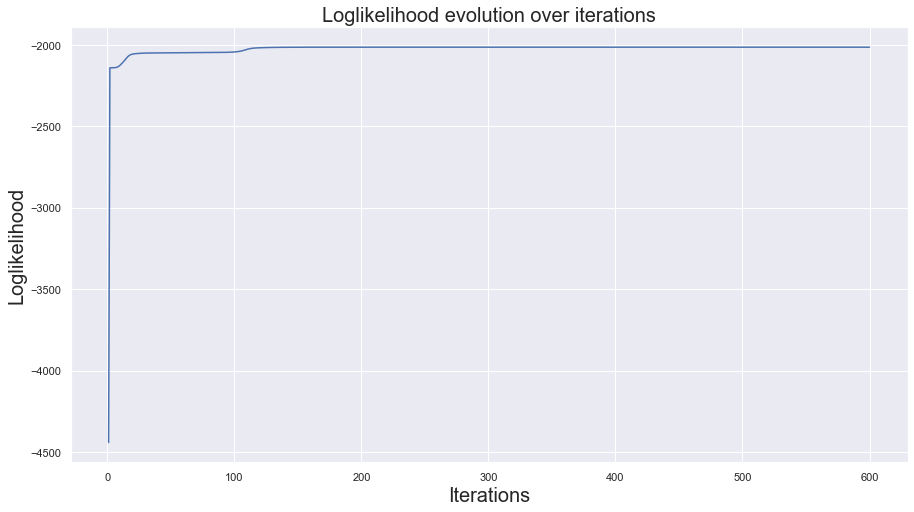

In [8]:
# Plot of the log-likelihood over the number of iterations
plt.plot(np.linspace(1, len(theta[-1]), len(theta[-1])), theta[-1])
plt.xlabel('Iterations', Fontsize=20)
plt.ylabel('Loglikelihood', Fontsize=20)
plt.title('Loglikelihood evolution over iterations', Fontsize=20)

#### Question 4.

We plot the Original gaussian mixture as well as the estimated one. We observe that they are very close. This means that the estimated parameters by the computed EM algorithm are not far from the original ones.

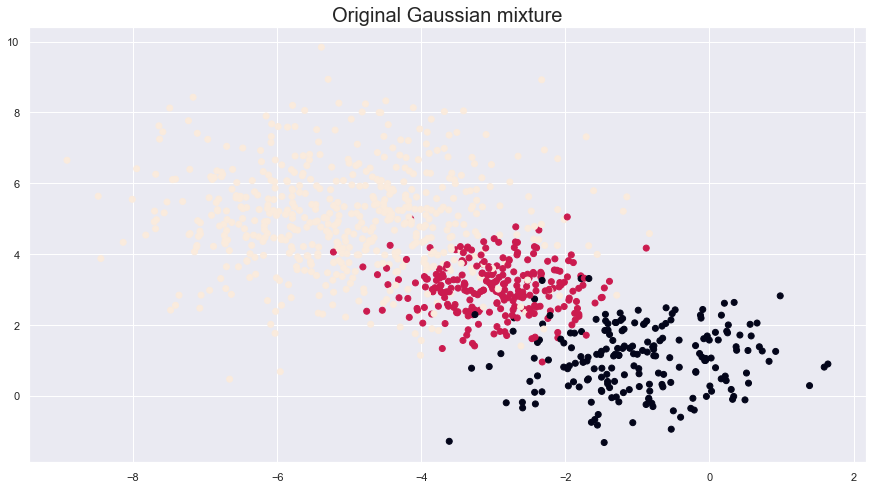

In [9]:
# Plot of the Original data
data_gmm, classes = sample_GMM(mu_0, alpha_0, sigma_0, n)
plt.scatter(data_gmm[:, 0], data_gmm[:, 1], c=classes)
plt.title('Original Gaussian mixture', Fontsize=20)

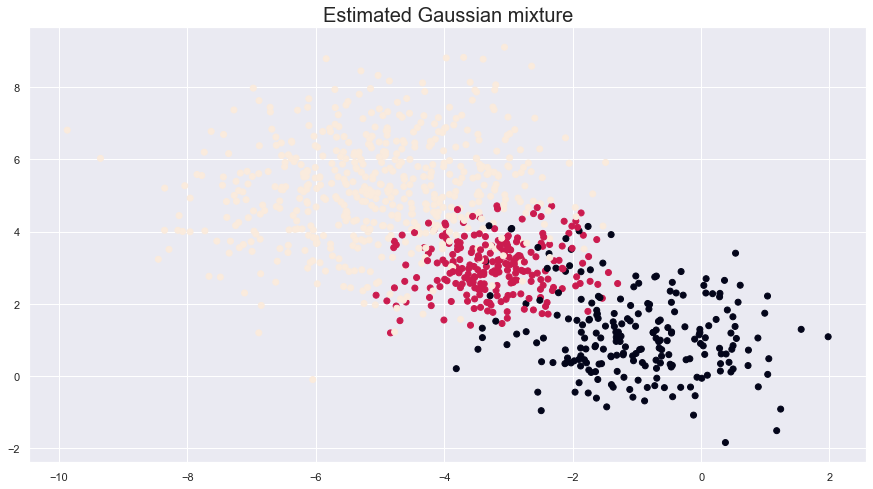

In [13]:
# Plot of the sampled data from the estimated parameters by EM algorithm
data_gmm_estimated, classes_estimated = sample_GMM(
    theta[0], theta[1], theta[2], n)
plt.scatter(data_gmm_estimated[:, 0],
            data_gmm_estimated[:, 1], c=classes_estimated)
plt.title('Estimated Gaussian mixture',  Fontsize=20);

#### Question 5.

**Application:** We upload the data Crude Birth/Death Rate and plot the associated scatter graph. 

In [5]:
# Upload Crude Birth/Death Rate data
data = pd.read_csv('WPP2019_Period_Indicators_Medium.csv')
data = data[['CBR','CDR']].iloc[:1000,:]
data.columns=['Crude Birth Rate', 'Crude Death Rate']
data = data.dropna()
data

,Crude Birth Rate,Crude Death Rate
0,50.314,36.862
1,50.998,33.718
2,51.477,30.808
3,51.646,28.223
4,51.234,25.495
...,...,...
995,44.122,15.505
996,41.639,13.662
997,37.459,11.415
998,32.814,9.343


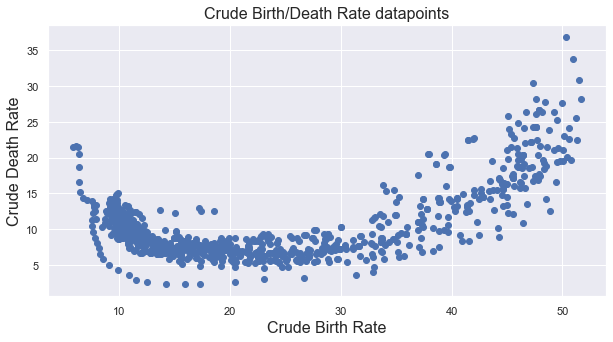

In [6]:
# Scatter plot of Crude Birth/Death Rate data
plt.figure(figsize=(10,5))
plt.scatter(np.array(data)[:,0],np.array(data)[:,1])
plt.xlabel('Crude Birth Rate',Fontsize=16)
plt.ylabel('Crude Death Rate',Fontsize=16)
plt.title('Crude Birth/Death Rate datapoints',Fontsize=16);

* Using a gaussian mixture model in this case to fit the data would be a pertinent idea. Indeed, the above plot indicates that a single gaussian cannot model the underlying data. Plus, the gaussian mixture model (GMM) is useful for modelling data that comes from several groups. And in our case, the data of birth and death rates comes from several countries. Thus, the idea of fitting for each country a gaussian model for birth/death rates is legitime, and so is the gaussian mixture model for the whole data.

#### Question 6.

#### 6.1. Estimated parameters of $\theta$ for different values of $m$.

In [39]:
# Apply the EM algorithm on the Crude Birth/Death Rate data for different numbers of clusters
m_s = [1, 2,3,4,5,6,8]
theta_s = []
for m in m_s:
    theta_s.append(EM(np.array(data),m, n_iter=100))

In [40]:
# Function to plot the probability density distribution over the scatter plots
def plot_pdf(X_0, X_1, classes, mu, alpha, sigma, m_opt):
    fig, ax = plt.subplots()
    plt.scatter(X_0, X_1, c=classes, cmap='viridis')
    x0, x1 = min(X_0), max(X_0)
    y0, y1 = min(X_1), max(X_1)
    x = np.arange(x0, x1, 0.005*(x1-x0))
    y = np.arange(y0, y1, 0.01*(y1-y0))
    nx, ny = len(x), len(y)
    x, y = np.meshgrid(x, y)
    invSigma = np.linalg.inv(sigma)
    detSigma = np.linalg.det(sigma)
    xc = x.reshape(ny, nx, 1, 1, 1) - mu[:, 0].reshape(m_opt, 1, 1)
    yc = y.reshape(ny, nx, 1, 1, 1) - mu[:, 1].reshape(m_opt, 1, 1)
    Xc = np.concatenate((xc, yc), 3)
    cov = Xc.transpose((0, 1, 2, 4, 3)) @ invSigma.reshape(1,
                                                           1, m_opt, 2, 2) @ Xc
    cov = cov.reshape(ny, nx, m_opt)
    z = np.exp(-0.5 * cov) * alpha / (detSigma * (2*np.pi)**2 + 1e-10) ** 0.5
    z = z.sum(2)
    plt.contour(x, y, z, levels=10*(m_opt**2))

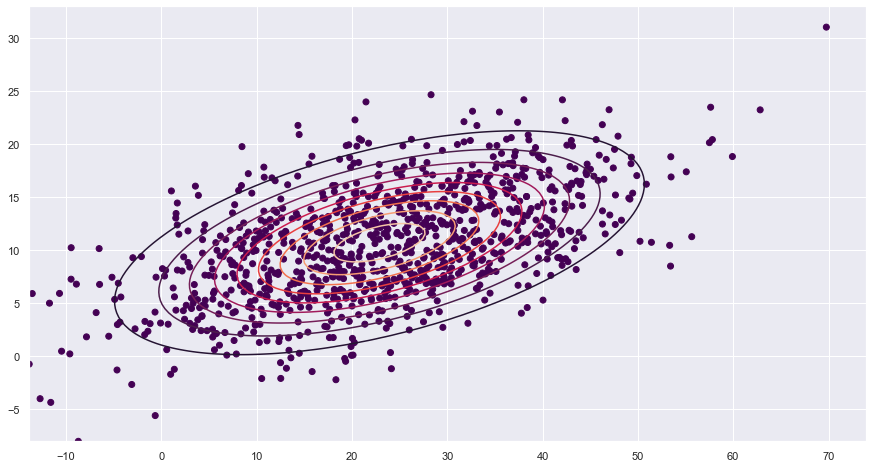

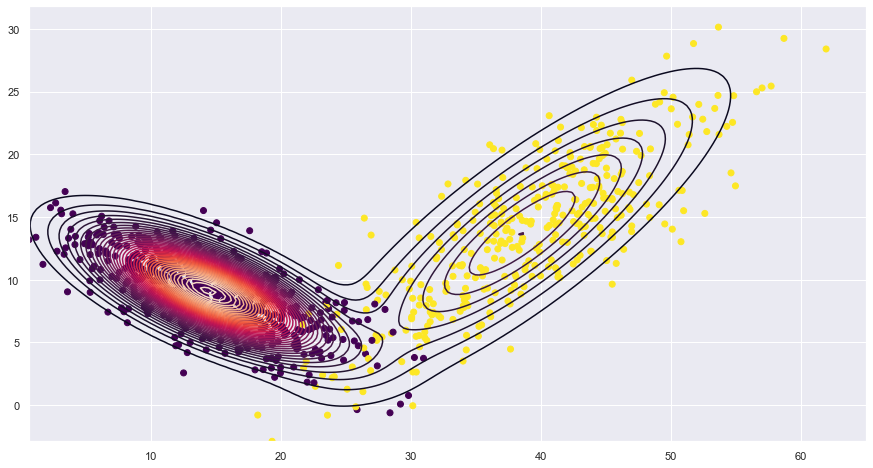

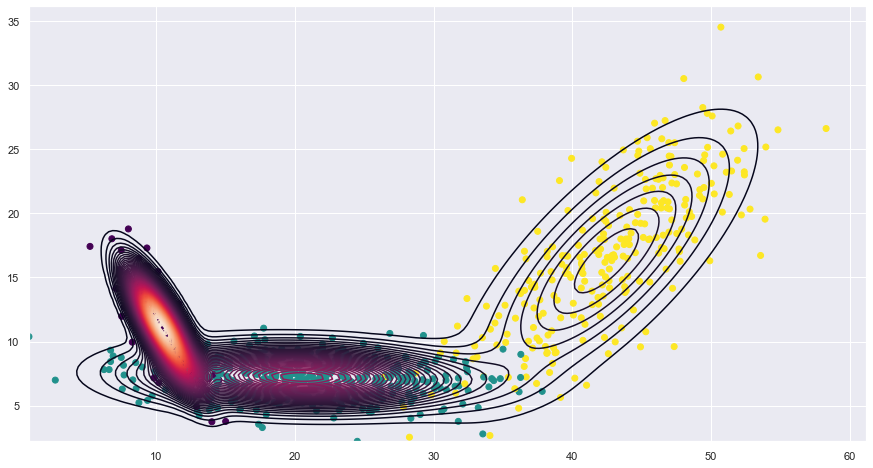

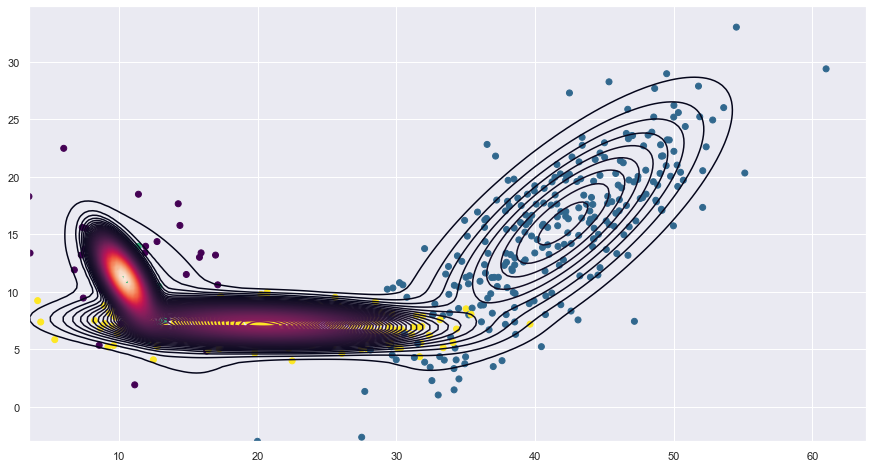

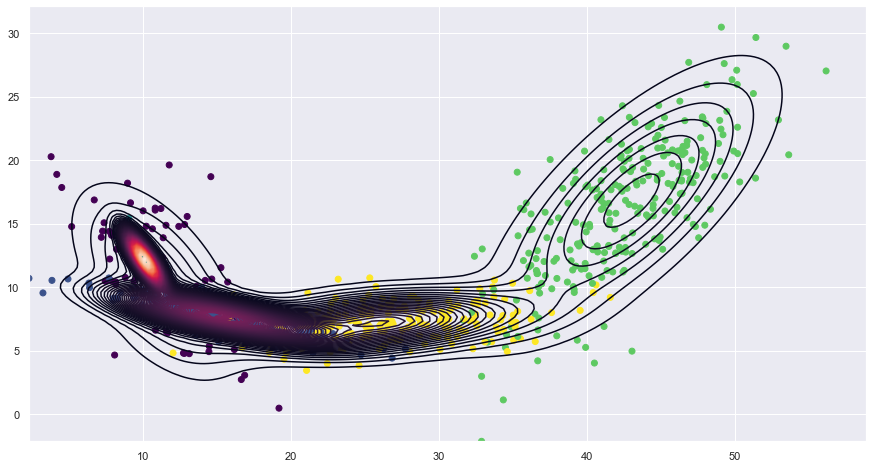

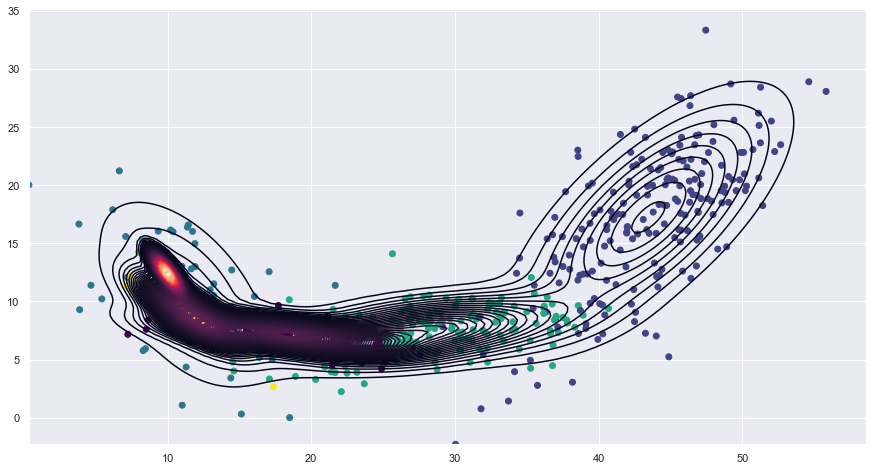

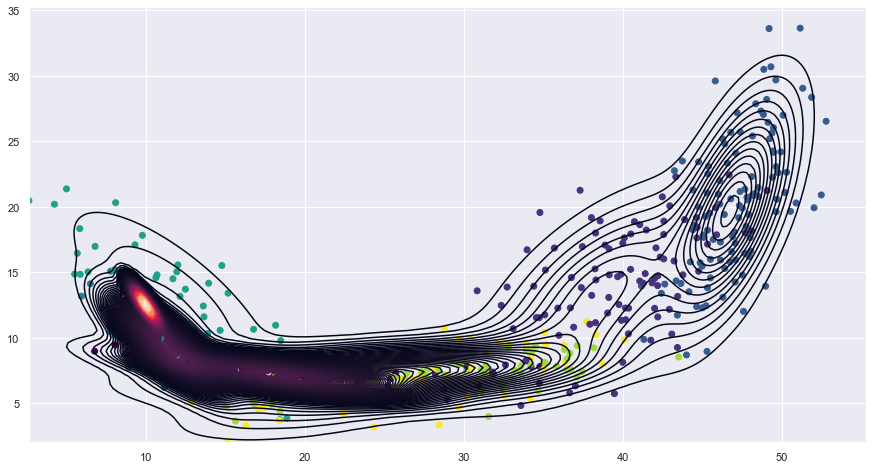

In [41]:
# Visualization of the different cases
for i in range(len(m_s)):
    data_estimated, classes_estimated = sample_GMM(
    theta_s[i][0], theta_s[i][1], theta_s[i][2], 1000)
    plot_pdf(data_estimated[:, 0], data_estimated[:, 1], classes_estimated, theta_s[i][0], theta_s[i][1], theta_s[i][2], m_s[i])

#### 6.2. BIC.

A good criterion to determine the right number of clusters is to minimize the BIC - Bayesian Information Criterion. 

$$\hat m = \underset{m \ge 1}{argmin} \{-log L(x_1,...,x_n;\theta) + \frac{df(m)log(n)}{2} \}$$

In [42]:
def BIC(X, nSteps, maxM, iters):
    n = len(X)
    maxM = min(n, maxM)
    best_score = float('inf')
    best_m = 0
    for m in range(1, maxM+1):
        for _ in range(iters):
            theta = EM(X, m, nSteps)
            alpha, mu, sigma, L = theta
            score = -L[-1] + 0.5*(5*m-1)*np.log(n)
            if score < best_score:
                best_m = m
                best_score = score
    return best_m, best_score

In [43]:
m_opt , _ = BIC(np.array(data), 15, 10, 3)
print('The optimal number of gaussians is {}.'.format(m_opt))

The optimal number of gaussians is 6.


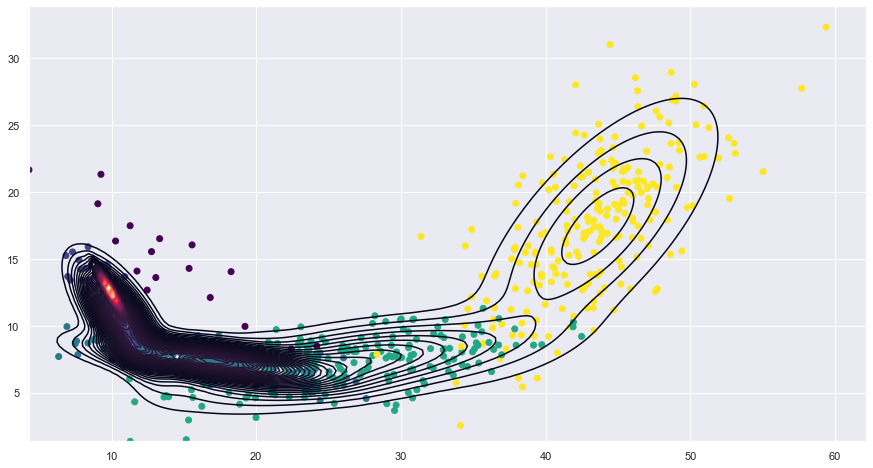

In [44]:
# Visualization for the optimal number of parameters
theta_opt = EM(np.array(data),m_opt, n_iter=100)
data_estimated, classes_estimated = sample_GMM(
theta_opt[0], theta_opt[1], theta_opt[2], 1000)
plot_pdf(data_estimated[:, 0], data_estimated[:, 1], classes_estimated, theta_opt[0], theta_opt[1], theta_opt[2], m_opt)

# Exercise 3. Importance sampling

## 3.A. Poor importance sampling

In this section, we will implement importance sampling in order to calculate the expectation of a function f defined by :

$$f(x) = 2~ sin(\frac{\pi}{1.5}x)\mathbf{1}_{\mathbb R}^+(x)$$

where $x$ is distributed according to a density $p$. <br>
We use a scaled normal distribution $N(0.8,1.5)$ as our sampling distribution where the parameters are chosen so that $p(x)<k~q(x)$ for all $x \in \mathbb{R_+}(x)$.

$$p(x) = x^{(1.65)-1} e^{-\frac{x^2}{2}} \mathbf{1}_{\mathbb{R}_+}(x)~~~~;~~~~q(x) = \frac{1}{\sqrt{2 \pi (1.5)}} e^{-\frac {(0.8 - x)^2}{2(1.5)}}$$

#### Question1.

In [23]:
# Define functions
def f(x):
    if x < 0: return 0
    return 2*np.sin(np.pi/1.5*x)
def p(x):
    if x<0: return 0
    return x**((1.65)-1)*np.exp(-x**2/2)
def q(x, mu, var):
    return 2/(np.sqrt(2*np.pi*var))*np.exp(-(mu-x)**2/(2*var))

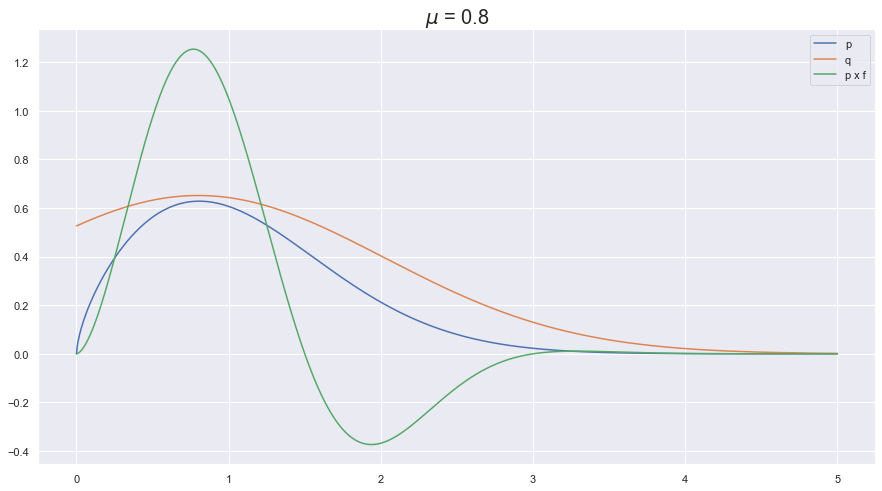

In [24]:
# Visualize functions
x = np.linspace(0, 5, 1000)
plt.plot(x,[p(x_i) for x_i in x], label = "p")
plt.plot(x,[q(x_i, 0.8, 1.5) for x_i in x], label = "q")
plt.plot(x,[p(x_i)*f(x_i) for x_i in x], label = "p x f")
plt.legend()
plt.title('$\mu$ = 0.8', Fontsize=20)
plt.show()

In [25]:
# Implementation of a simple importance sampling procedure
def importance_sampling(N, mu, var):
    # compute positive samples from normal distribution
    x = np.random.normal(size=N, loc=mu, scale=var)
    x = x[x >= 0]
    while len(x) < N:
        x = list(x)
        x.append(np.random.normal(size=1, loc=mu, scale=var)[0])
        x = np.array(x)
        x = x[x >= 0]
    x = x[np.argsort(x)]
    # compute weights
    w = [p(x_i)/q(x_i, mu, var) for x_i in x]
    w_tilde = w/sum(w)
    # compute estimate
    E_q = np.sum([w_tilde[i]*f(x[i]) for i in range(len(x))])
    return E_q, w

In [26]:
E_q = importance_sampling(1000, 0.8, 1.5)[0]
print('The estimate is equal to ',E_q,'.')

The estimate is equal to  0.6687447397515243 .


#### Question2.

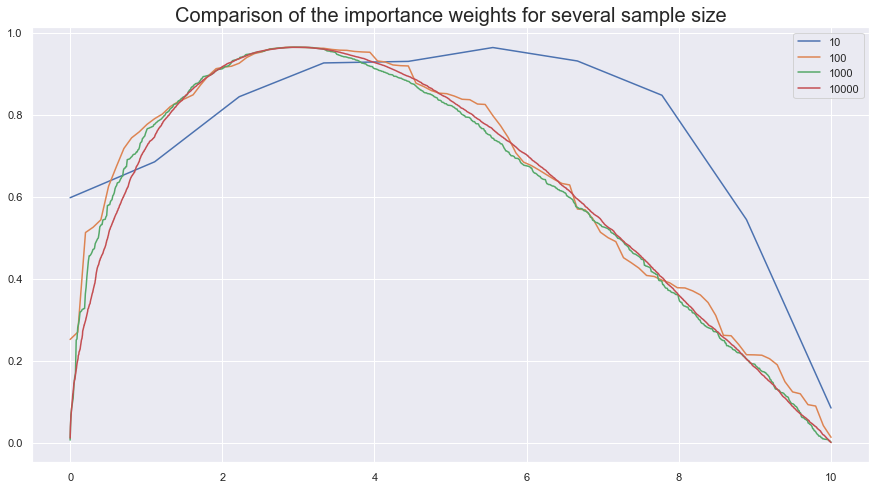

Comparison of the Estimate for several sample size:


,N,Eq
0,10,0.518002
1,100,0.665927
2,1000,0.666440
3,10000,0.670305


In [27]:
Ns = [10, 100, 1000, 10000]
E_q_Ns = []
w_Ns = []
for N in Ns:
    E_q_Ns.append(importance_sampling(N, 0.8, 1.5)[0])
    w_Ns.append(importance_sampling(N, 0.8, 1.5)[1])

# Compare weights for several sample size
for i,w in enumerate(w_Ns):
    plt.plot(np.linspace(0,10,len(w)),w,label=Ns[i])
plt.legend()
plt.title('Comparison of the importance weights for several sample size',Fontsize=20)
plt.show()

# Compare estimate for several sample size
print('Comparison of the Estimate for several sample size:')
df_estimate = pd.DataFrame(E_q_Ns)
df_Ns = pd.DataFrame(Ns)
df = pd.concat([df_Ns, df_estimate], axis=1)
df.columns = ['N', 'Eq']
df.head()

* We observe that the estimates are almost all the same when considering $\mu = 0.8$.

#### Question3.

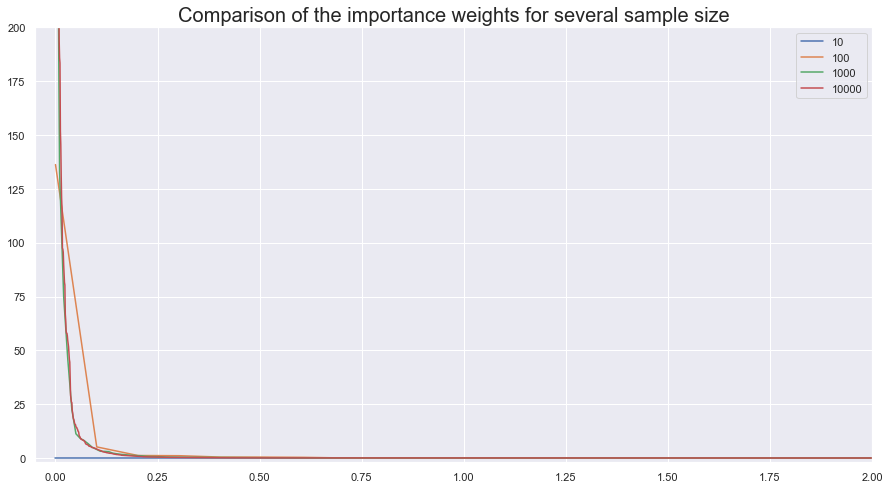

Comparison of the Estimate for several sample size:


,N,Eq
0,10,1.638589
1,100,-0.337483
2,1000,1.695376
3,10000,1.188483


In [28]:
# shift the mean
mu = 6
Ns = [10, 100, 1000, 10000]

E_q_Ns = []
w_Ns = []
import pandas as pd
for N in Ns:
    E_q_Ns.append(importance_sampling(N, mu, 1.5)[0])
    w_Ns.append(importance_sampling(N, mu, 1.5)[1])

# Compare weights for several sample size
for i,w in enumerate(w_Ns):
    plt.plot(np.linspace(0,10,len(w)),w,label=Ns[i])
plt.legend()
plt.title('Comparison of the importance weights for several sample size',Fontsize=20)
plt.xlim(-0.05,2)
plt.ylim(-2,200)
plt.show()

# Compare estimate for several sample size
print('Comparison of the Estimate for several sample size:')
df_estimate = pd.DataFrame(E_q_Ns)
df_Ns = pd.DataFrame(Ns)
df = pd.concat([df_Ns, df_estimate], axis=1)
df.columns = ['N', 'Eq']
df.head()

* We notice that with a shifted mean $\mu$ from $0.8$ to $6$, the estimates are so different and with positive and negative values.

## 3.B. Adaptative importance sampling


The $(iii)$ step amounts to maximize $\sum_{i=1}^n \tilde{w_i}^{(0)} log (\sum_{j=1}^M \alpha_j \phi (X_i^{(0)}; \theta_j))$. This resembles to the objective of the maximization step of the Expectation-Maximization algorithm but with additional weights.

Thus, the EM algorithm can be used to maximize the empirical criterion in step $(iii)$ and the parameters update would be written as follows:
   * $\mu_j = \frac{\sum_{n=1}^N \tilde{w_n} \tau_{n,j} x_n} {\sum_{n=1}^N \tilde{w_n} \tau_{n,j}}$ <br><br>
   * $\Sigma_j = \frac{\sum_{n=1}^N \tilde{w_n} \tau_{n,j} (x_n - \mu_j)(x_n - \mu_j)^T}{\sum_{n=1}^N \tilde{w_n} \tau_{n,j}}$ <br> <br>
   * $\alpha_j = \frac{  \sum_{n=1}^N \tilde{w_n}\tau_{n,j} }{ \sum_{n=1}^N \sum_{j=1}^K \tilde{w_n}\tau_{n,j}} $

## 3.C. Application to a "banana"-shaped density

Let's consider:

$$\forall x=(x_1,...,x_d) \in \mathbb{R}^d, ~~\nu(x) \propto \phi(x_1, x_2+b(x_1^2-\sigma_1^2),x_3,...,x_d)$$

Taking $d=5, \sigma_1^2=1,$ and $b=0.4,~\nu$ results in a banana-shaped density in the first two dimensions.

#### Computation of the banana-shaped density.

In [29]:
def banana_shape(n, d, sigma, b):
    cov = np.eye(d)
    cov[0,0] = sigma**2
    mu = np.zeros(d)
    # sample a gaussian distribution with mean mu and covariance sigma
    mu_x = np.random.multivariate_normal(mu, cov, n)
    # shift the second coordinate
    mu_x[:, 1] = mu_x[:, 1]+b*(mu_x[:, 0]**2-cov[0,0])
    return mu_x

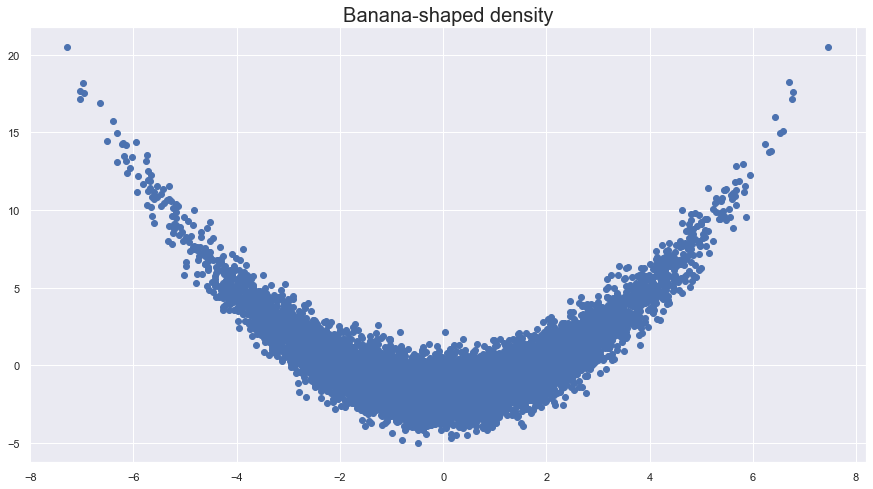

In [30]:
# Simulate the banana shape
banana = banana_shape(n=10000, d=5, sigma=2, b=0.4)
# Plot first two coordinates of the banana-shaped density
plt.scatter(banana[:,0],banana[:,1])
plt.title('Banana-shaped density', Fontsize=20);

#### Adaptative Importance Sampling to draw samples from the density of the banana-shape.

Using the adaptative Importance Sampling, we'll try to draw samples from the density $\nu$. <br>
To do so, we'll apply the Population Monte Carlo Algorithm to approximate $\nu$ from a family of distributions $Q$, then draw samples according to the found distribution.<br>
As $Q$ is chosen to be the family of mixtures of M gaussian distributions on $\mathbb{R}^d$, we try to approximate $\nu$ with a GMM whose parameters are updated using the EM algorithm as explained in $Question4.$

For that, we define the following **Adaptative_EM** method which adds **weights** to the probability dentsity computed in the E step. 

In [31]:
def Adaptative_EM(d, sigma_banana, b, max_outer_iter=100, max_inner_iter=10, k=10):
    # initialize parameters
    sigma = k*[np.random.uniform(10, size=1)*np.eye(d)]
    mu = [np.random.uniform(size=d) for x in range(k)]
    alpha = np.ones(k)/k
    # population monte carlo algorithm    
    n_iter = 0
    for _ in tqdm(range(max_outer_iter)):
        # simulate X from mixture gaussian distribution (Q family) with the obtained EM parameters 
        simulations = sample_GMM(mu, alpha, sigma, n=10000)[0]
        # compute weights
        w = Banana_density(simulations,sigma_banana,d,b) / GMM_density(simulations,alpha,mu,sigma)
        # apply EM algorithm
        iner_iter = 0
        for _ in range(max_inner_iter):
            # E-step
            tau, _ = Adaptative_E_step(simulations, alpha, mu, sigma)
            # M-step
            mu, alpha, sigma = Adaptative_M_step(simulations, tau, w)
            iner_iter += 1
        n_iter += 1
    return alpha, mu, sigma

def Adaptative_E_step(data, alpha, mu, sigma):
    tau = np.zeros((data.shape[0], len(alpha)))
    for j in np.arange(0, len(alpha)):
        tau[:, j] = alpha[j] * \
            multivariate_normal.pdf(data, mu[j], sigma[j], allow_singular=True)
    denominator = np.apply_along_axis(np.sum, 1, tau)
    loglike = np.log(denominator)
    loglike = np.sum(loglike)
    for j in np.arange(0, len(alpha)):
        tau[:, j] = tau[:, j]/denominator
    return tau, loglike

def Adaptative_M_step(data, tau, w):
    sigma = []
    mu = []
    alpha = np.zeros(tau.shape[1])
    for j in np.arange(0, tau.shape[1]):
        alpha[j] = np.sum(w*tau[:, j])
        mu.append(np.average(data, weights=tau[:, j]*w, axis=0))
        data_centered = data-mu[j]
        aux_sigma = 0
        for i in range(data.shape[0]):
            aux_sigma += tau[i, j]*w[i] * \
                np.outer(data_centered[i], data_centered[i])
        aux_sigma = aux_sigma/np.sum(tau[:, j]*w)
        sigma.append(aux_sigma)
    alpha = alpha/np.sum(alpha)
    return mu, alpha, sigma

In [32]:
def Banana_density(data,sigma,d,b):
    cov = np.eye(d)
    cov[0,0] = sigma**2
    mu = np.zeros(d)
    data_copy =copy.deepcopy(data)
    data_copy[:,1]=data_copy[:,1]+b*(data_copy[:,0]**2-cov[0,0])
    banana_simulation = multivariate_normal.pdf(data_copy,mu,cov)
    return banana_simulation

def GMM_density(data,alpha,mu,sigma):
    loglike=np.zeros((data.shape[0],len(alpha)))
    for j in range(len(alpha)):
            loglike[:,j]=alpha[j]*multivariate_normal.pdf(data,mu[j],sigma[j])
    GMM_simulation=np.sum(loglike,axis=1)
    return GMM_simulation

We apply the adaptative importance sampling for different parameters for the banana-shaped density as well as the number of clusters $k$ and we plot the results of the first two coordinates.

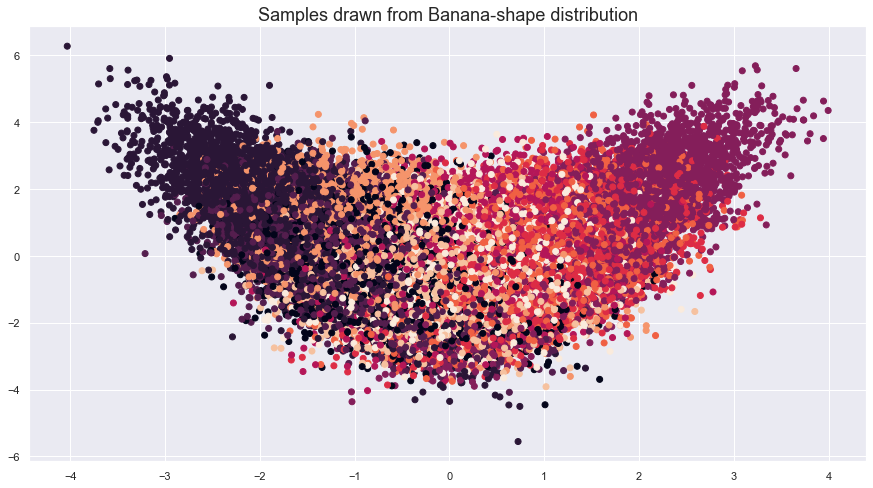

In [33]:
# apply the adaptative importance sampling
alpha, mu, sigma =Adaptative_EM(d=4,sigma_banana=1,b=0.4,max_outer_iter=100,max_inner_iter=1,k=10)
# simulate mixture gaussian from the optimal parameters
X, classes = sample_GMM(mu, alpha, sigma, n=100000)
# visualization
plt.scatter(X[:,0],-1*X[:,1],c=classes)
plt.title('Samples drawn from Banana-shape distribution', Fontsize = 18);

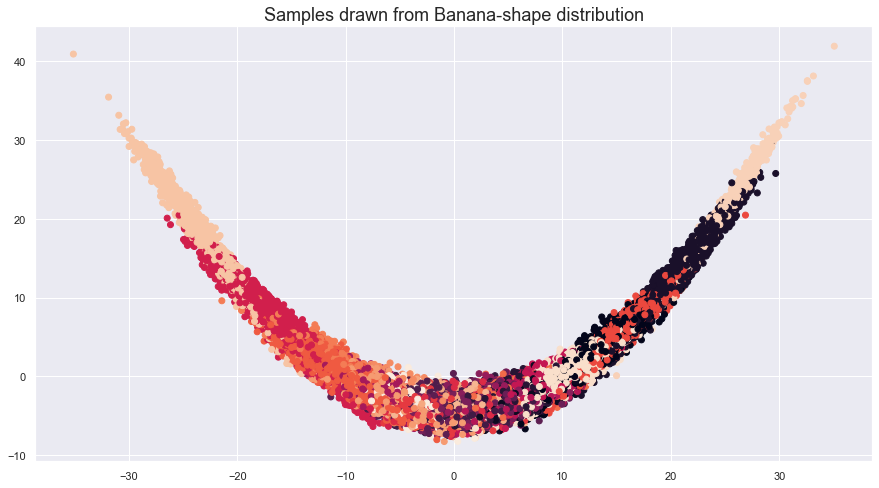

In [35]:
# apply the adaptative importance sampling
alpha, mu, sigma =Adaptative_EM(d=4,sigma_banana=10,b=0.04,max_outer_iter=100,max_inner_iter=1,k=30)
# simulate mixture gaussian from the optimal parameters
X, classes = sample_GMM(mu, alpha, sigma, n=100000)
# visualization
plt.scatter(X[:,0],-1*X[:,1],c=classes)
plt.title('Samples drawn from Banana-shape distribution', Fontsize = 18);

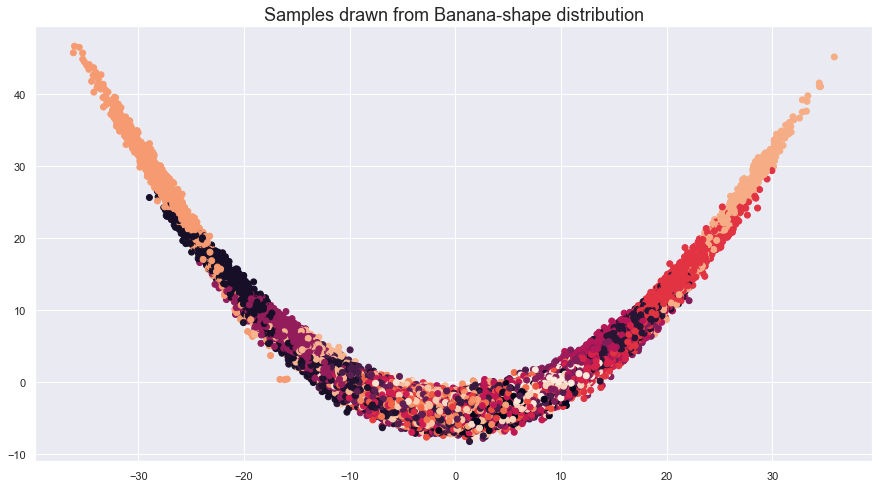

In [36]:
# apply the adaptative importance sampling
alpha, mu, sigma =Adaptative_EM(d=4,sigma_banana=10,b=0.04,max_outer_iter=100,max_inner_iter=1,k=50)
# simulate mixture gaussian from the optimal parameters
X, classes = sample_GMM(mu, alpha, sigma, n=100000)
# visualization
plt.scatter(X[:,0],-1*X[:,1],c=classes)
plt.title('Samples drawn from Banana-shape distribution', Fontsize = 18);

#### **Comment:** <br>
We clearly observe that the results correspond indeed to a banana-shape. Thus, we put forward the **Adaptative Importance Sampling** method in order to sample from another distribution to obtain a target distributin through an approximation of the minimization of the Kullback-Leider divergence that measures how distant are the two given distributions.